In [ ]:
# # This Python 3 environment comes with many helpful analytics libraries installed
# # It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# # For example, here's several helpful packages to load

# import numpy as np # linear algebra
# import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# # Input data files are available in the read-only "../input/" directory
# # For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

# import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

# # You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All"
# # You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [ ]:
# Cell 1: Environment Setup & Medical EDA

Total Images: 32072


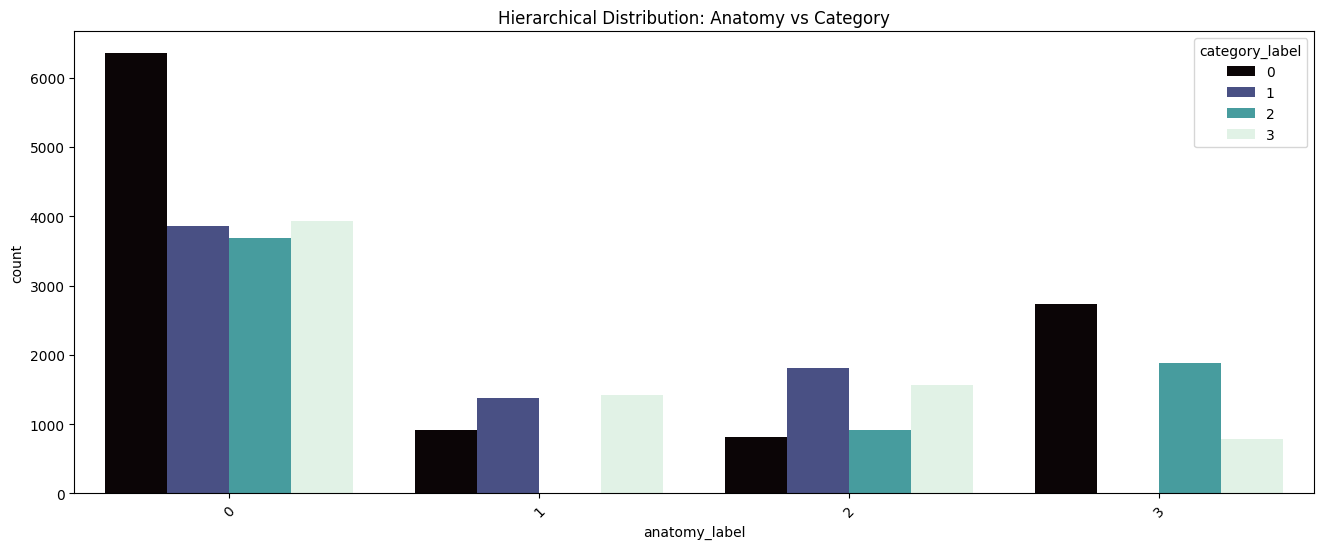

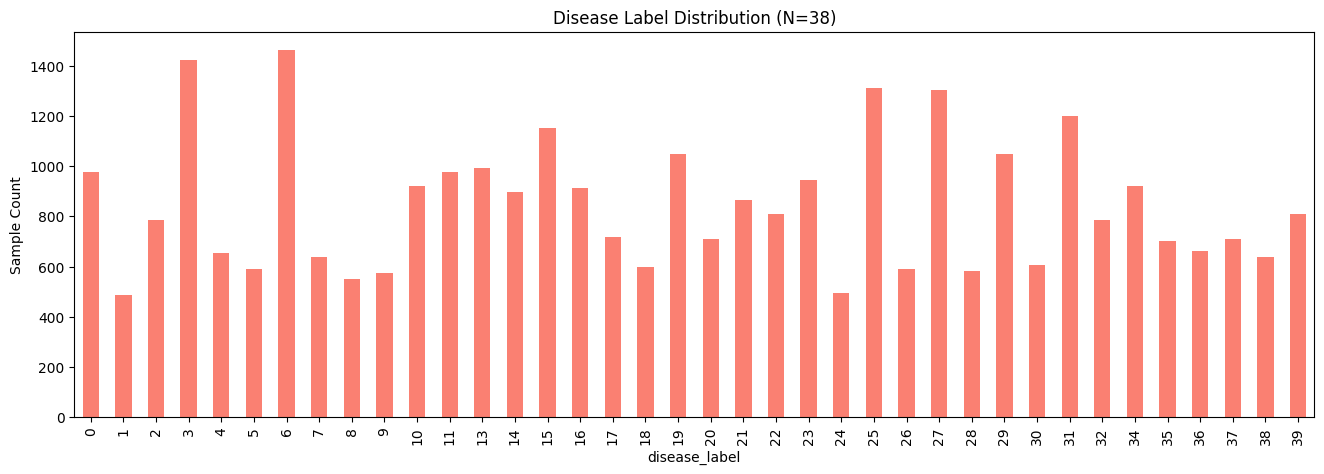

In [ ]:
import os, pandas as pd, numpy as np, matplotlib.pyplot as plt, seaborn as sns
from PIL import Image
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score

# Configuration for Kaggle Environment
BASE_DIR = "/kaggle/input/mri-dataset/dataset" # Update with your Kaggle dataset slug
CSV_PATH = os.path.join(BASE_DIR, "training_metadata.csv")

df = pd.read_csv(CSV_PATH)

# EDA: Hierarchy visualization (Required for Paper Figure 1)
print(f"Total Images: {len(df)}")
plt.figure(figsize=(16, 6))
sns.countplot(data=df, x='anatomy_label', hue='category_label', palette='mako')
plt.title("Hierarchical Distribution: Anatomy vs Category")
plt.xticks(rotation=45)
plt.show()

# Per-class distribution for the 38 diseases (Identify 'Long Tail' issues)
plt.figure(figsize=(16, 5))
df['disease_label'].value_counts().sort_index().plot(kind='bar', color='salmon')
plt.title("Disease Label Distribution (N=40)")
plt.ylabel("Sample Count")
plt.show()

In [ ]:
#Cell 2: Medical-Grade Augmentation & Data Loaders

In [ ]:
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models

# Stratified Split (Ensures all 38 diseases are represented in test set)
train_val, test_df = train_test_split(df, test_size=0.15, stratify=df['disease_label'], random_state=42)
train_df, val_df = train_test_split(train_val, test_size=0.15, stratify=train_val['disease_label'], random_state=42)

# Augmentation Strategy: Affine + Photometric (Standard for MRI/X-ray)
train_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15), # Standard for medical variance
    transforms.RandomAffine(degrees=0, translate=(0.1, 0.1)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

test_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

class HierarchicalDataset(Dataset):
    def __init__(self, dataframe, transform=None):
        self.df = dataframe
        self.transform = transform
    def __len__(self): return len(self.df)
    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        img = Image.open(os.path.join(BASE_DIR, row['file_path'])).convert('RGB')
        if self.transform: img = self.transform(img)
        return img, row['anatomy_label'], row['category_label'], row['disease_label']

train_loader = DataLoader(HierarchicalDataset(train_df, train_transforms), batch_size=64, shuffle=True)
val_loader = DataLoader(HierarchicalDataset(val_df, test_transforms), batch_size=64)
test_loader = DataLoader(HierarchicalDataset(test_df, test_transforms), batch_size=64)

In [ ]:
#Cell 3: Hierarchical CNN Architecture

In [ ]:
import torch
import torch.nn as nn
from torchvision import models

# 1. THE ARCHITECTURE (Must be defined first)
class HierarchicalResNet(nn.Module):
    def __init__(self, n_anatomy, n_category, n_disease):
        super().__init__()
        self.backbone = models.resnet18(weights='IMAGENET1K_V1')
        in_feats = self.backbone.fc.in_features
        self.backbone.fc = nn.Identity()

        self.anatomy_head = nn.Linear(in_feats, n_anatomy)
        self.category_head = nn.Linear(in_feats, n_category)
        self.disease_head = nn.Linear(in_feats, n_disease)

    def forward(self, x):
        features = self.backbone(x)
        return self.anatomy_head(features), self.category_head(features), self.disease_head(features)

# 2. DIMENSIONS & WEIGHTS
NUM_ANATOMY = df['anatomy_label'].max() + 1
NUM_CATEGORY = df['category_label'].max() + 1
NUM_DISEASE = df['disease_label'].max() + 1

# Re-calculate weights for the loss function (Standard paper requirement)
disease_counts = train_df['disease_label'].value_counts()
weights_d = torch.ones(NUM_DISEASE)
for cls_idx, count in disease_counts.items():
    weights_d[cls_idx] = 1.0 / (count + 1e-6)
weights_d = (weights_d / weights_d.sum()) * NUM_DISEASE
weights_d = weights_d.to('cuda')

# 3. INITIALIZE MODEL & OPTIMIZER
model = HierarchicalResNet(NUM_ANATOMY, NUM_CATEGORY, NUM_DISEASE).to('cuda')
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
criterion = nn.CrossEntropyLoss()
criterion_d = nn.CrossEntropyLoss(weight=weights_d)

print("Model structure initialized. Ready for training.")

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


100%|██████████| 44.7M/44.7M [00:00<00:00, 202MB/s]


Model structure initialized. Ready for training.


In [ ]:
#Cell 4: Conference Evaluation Suite (Accuracy, F1, Per-Class)

Epoch 01/15:   0%|          | 0/363 [00:00<?, ?it/s]

Epoch 1 Summary: Loss: 2.3395 | Acc: 0.8188 | F1: 0.8111


Epoch 02/15:   0%|          | 0/363 [00:00<?, ?it/s]

Epoch 2 Summary: Loss: 0.7645 | Acc: 0.8888 | F1: 0.8813


Epoch 03/15:   0%|          | 0/363 [00:00<?, ?it/s]

Epoch 3 Summary: Loss: 0.4844 | Acc: 0.9012 | F1: 0.8939


Epoch 04/15:   0%|          | 0/363 [00:00<?, ?it/s]

Epoch 4 Summary: Loss: 0.4012 | Acc: 0.8978 | F1: 0.8925


Epoch 05/15:   0%|          | 0/363 [00:00<?, ?it/s]

Epoch 5 Summary: Loss: 0.3473 | Acc: 0.9159 | F1: 0.9014


Epoch 06/15:   0%|          | 0/363 [00:00<?, ?it/s]

Epoch 6 Summary: Loss: 0.2923 | Acc: 0.9100 | F1: 0.9011


Epoch 07/15:   0%|          | 0/363 [00:00<?, ?it/s]

Epoch 7 Summary: Loss: 0.3188 | Acc: 0.9156 | F1: 0.9079


Epoch 08/15:   0%|          | 0/363 [00:00<?, ?it/s]

Epoch 8 Summary: Loss: 0.2784 | Acc: 0.9276 | F1: 0.9104


Epoch 09/15:   0%|          | 0/363 [00:00<?, ?it/s]

Epoch 9 Summary: Loss: 0.2517 | Acc: 0.9227 | F1: 0.9106


Epoch 10/15:   0%|          | 0/363 [00:00<?, ?it/s]

Epoch 10 Summary: Loss: 0.2381 | Acc: 0.9222 | F1: 0.9140


Epoch 11/15:   0%|          | 0/363 [00:00<?, ?it/s]

Epoch 11 Summary: Loss: 0.2243 | Acc: 0.9232 | F1: 0.9107


Epoch 12/15:   0%|          | 0/363 [00:00<?, ?it/s]

Epoch 12 Summary: Loss: 0.2594 | Acc: 0.9198 | F1: 0.9082


Epoch 13/15:   0%|          | 0/363 [00:00<?, ?it/s]

Epoch 13 Summary: Loss: 0.2339 | Acc: 0.9105 | F1: 0.9006


Epoch 14/15:   0%|          | 0/363 [00:00<?, ?it/s]

Epoch 14 Summary: Loss: 0.2289 | Acc: 0.9198 | F1: 0.9134


Epoch 15/15:   0%|          | 0/363 [00:00<?, ?it/s]

Epoch 15 Summary: Loss: 0.2356 | Acc: 0.9252 | F1: 0.9187


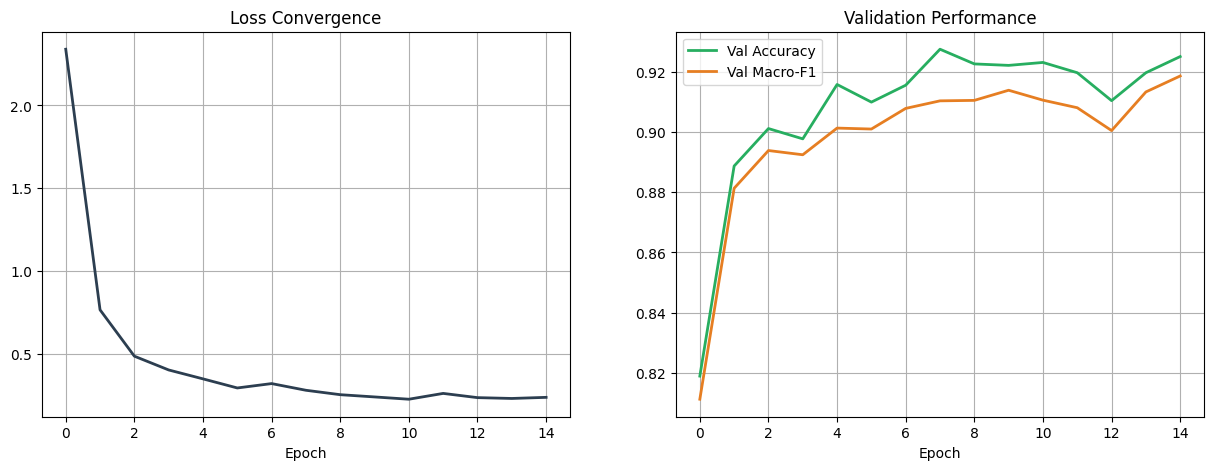

              precision    recall  f1-score   support

           0       0.64      0.71      0.67       146
           1       0.29      0.23      0.26        73
           2       0.98      1.00      0.99       118
           3       0.96      1.00      0.98       214
           4       0.48      0.36      0.41        98
           5       1.00      0.99      0.99        89
           6       1.00      1.00      1.00       220
           7       0.98      0.99      0.98        96
           8       1.00      0.99      0.99        83
           9       1.00      1.00      1.00        86
          10       0.57      0.80      0.66       138
          11       0.99      1.00      0.99       146
          13       1.00      1.00      1.00       149
          14       1.00      0.99      1.00       134
          15       0.99      0.98      0.98       173
          16       0.99      0.97      0.98       137
          17       0.99      1.00      1.00       108
          18       1.00    

In [ ]:
import torch
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix

# --- 1. THE EVALUATION FUNCTION (Must be inside this cell) ---
def run_evaluation(loader, model, num_classes):
    model.eval()
    all_true, all_pred = [], []
    with torch.no_grad():
        for imgs, a, c, d in loader:
            _, _, logits_d = model(imgs.to('cuda'))
            all_true.extend(d.numpy())
            all_pred.extend(logits_d.argmax(1).cpu().numpy())

    acc = accuracy_score(all_true, all_pred)
    f1 = f1_score(all_true, all_pred, average='macro')
    return acc, f1, all_true, all_pred

# --- 2. THE PLOTTING FUNCTION ---
def plot_progress(losses, accs, f1s):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
    ax1.plot(losses, label='Training Loss', color='#2c3e50', lw=2)
    ax1.set_title('Loss Convergence')
    ax1.set_xlabel('Epoch')
    ax1.grid(True)

    ax2.plot(accs, label='Val Accuracy', color='#27ae60', lw=2)
    ax2.plot(f1s, label='Val Macro-F1', color='#e67e22', lw=2)
    ax2.set_title('Validation Performance')
    ax2.set_xlabel('Epoch')
    ax2.legend()
    ax2.grid(True)
    plt.show()

# --- 3. MAIN TRAINING LOOP ---
train_losses, val_accs, val_f1s = [], [], []

# Change range to 15 for your final paper run
for epoch in range(15):
    model.train()
    total_loss = 0
    pbar = tqdm(train_loader, desc=f"Epoch {epoch+1:02d}/15")

    for imgs, a, c, d in pbar:
        optimizer.zero_grad()
        oa, oc, od = model(imgs.to('cuda'))

        loss = criterion(oa, a.to('cuda')) + \
               criterion(oc, c.to('cuda')) + \
               criterion_d(od, d.to('cuda'))

        loss.backward()
        optimizer.step()
        total_loss += loss.item()
        pbar.set_postfix({"loss": f"{loss.item():.4f}"})

    # Now 'run_evaluation' is defined, so this won't crash
    v_acc, v_f1, _, _ = run_evaluation(val_loader, model, NUM_DISEASE)

    train_losses.append(total_loss / len(train_loader))
    val_accs.append(v_acc)
    val_f1s.append(v_f1)
    print(f"Epoch {epoch+1} Summary: Loss: {train_losses[-1]:.4f} | Acc: {v_acc:.4f} | F1: {v_f1:.4f}")

# --- 4. FINAL VISUALS & SAVING ---
plot_progress(train_losses, val_accs, val_f1s)

test_acc, test_f1, y_true, y_pred = run_evaluation(test_loader, model, NUM_DISEASE)
print(classification_report(y_true, y_pred, zero_division=0))

# Final Save
torch.save(model.state_dict(), "final_hierarchical_model.pth")

In [ ]:
from collections import defaultdict

def per_class_accuracy(model, loader, df_labels, level="disease"):
    model.eval()
    correct = defaultdict(int)
    total = defaultdict(int)

    # Check if 'disease_name' exists, otherwise use IDs
    if level == "disease" and 'disease_name' in df_labels.columns:
        idx2name = df_labels[['disease_label', 'disease_name']].drop_duplicates().set_index('disease_label')['disease_name'].to_dict()
    elif level == "anatomy" and 'anatomy_name' in df_labels.columns:
         idx2name = df_labels[['anatomy_label', 'anatomy_name']].drop_duplicates().set_index('anatomy_label')['anatomy_name'].to_dict()
    else:
        # Fallback to just using the ID numbers
        idx2name = {}

    with torch.no_grad():
        for imgs, a, c, d in loader:
            # Change 'device' to 'cuda' for your specific setup
            imgs, a, c, d = imgs.to('cuda'), a.to('cuda'), c.to('cuda'), d.to('cuda')
            a_out, c_out, d_out = model(imgs)

            if level=="anatomy":
                preds = a_out.argmax(1); labels = a
            elif level=="category":
                preds = c_out.argmax(1); labels = c
            elif level=="disease":
                preds = d_out.argmax(1); labels = d

            for p, t in zip(preds.cpu(), labels.cpu()):
                total[t.item()] += 1
                if p.item() == t.item():
                    correct[t.item()] += 1

    print(f"\nDetailed Per-class accuracy for {level.upper()}:")
    print("-" * 50)
    for cls_idx in sorted(total.keys()):
        name = idx2name.get(cls_idx, f"Class {cls_idx}")
        acc = correct[cls_idx] / total[cls_idx]
        print(f"{name:<30} | {acc*100:>6.2f}% ({correct[cls_idx]}/{total[cls_idx]})")

# RUN THIS FOR YOUR PAPER DATA
per_class_accuracy(model, test_loader, df, level="disease")
per_class_accuracy(model, test_loader, df, level="anatomy")


Detailed Per-class accuracy for DISEASE:
--------------------------------------------------
Acute Cerebellitis in HIV      |  70.55% (103/146)
Acute Unilateral Cerebellitis in HIV |  23.29% (17/73)
Adenomyosis in Gravid Uterus   | 100.00% (118/118)
Balloon Cell Cortical Dysplasia | 100.00% (214/214)
Bilateral Osgood-Schlatter Disease with Chronic Inflammatory Arthritis |  35.71% (35/98)
Bilateral Ulnar Impaction Syndrome |  98.88% (88/89)
Carolis Disease                |  99.55% (219/220)
Congenital Toxoplasmosis       |  98.96% (95/96)
Congenital Vaginal Cyst        |  98.80% (82/83)
Dermatomyositis                | 100.00% (86/86)
Fukuyama Muscular Dystrophy    |  79.71% (110/138)
Gamekeepers Thumb              | 100.00% (146/146)
Hepatocellular Carcinoma (HCC) and Dysplastic Nodules with Cirrhosis | 100.00% (149/149)
Inferior Vena Cava (IVC) Leiomyosarcoma |  99.25% (133/134)
Japanese B Encephalitis or Epstein-Barr Encephalitis |  97.69% (169/173)
Leighs Disease in Spinal Cord and 

In [ ]:
#save the model

In [ ]:
# Define the path where you want to save the model
# In Kaggle, use '/kaggle/working/hierarchical_mri_model.pth'
# In Colab, use '/content/hierarchical_mri_model.pth'
SAVE_PATH = "/kaggle/working/hierarchical_mri_model_15epoch.pth"

# Create a dictionary to save both weights and metadata
checkpoint = {
    'model_state_dict': model.state_dict(),
    'num_anatomy': NUM_ANATOMY,
    'num_category': NUM_CATEGORY,
    'num_disease': NUM_DISEASE,
    'class_weights': weights_d.cpu() # Save weights for reproducibility
}

torch.save(checkpoint, SAVE_PATH)
print(f"Model successfully saved to {SAVE_PATH}")

Model successfully saved to /kaggle/working/hierarchical_mri_model_15epoch.pth


In [ ]:
# Loading the Model Later

In [ ]:
# def load_trained_model(path, device='cuda'):
#     # 1. Load the checkpoint
#     checkpoint = torch.load(path, map_location=device)

#     # 2. Re-initialize the architecture with saved dimensions
#     loaded_model = HierarchicalResNet(
#         checkpoint['num_anatomy'],
#         checkpoint['num_category'],
#         checkpoint['num_disease']
#     )

#     # 3. Load the weights
#     loaded_model.load_state_dict(checkpoint['model_state_dict'])
#     loaded_model.to(device)
#     loaded_model.eval() # Set to evaluation mode

#     return loaded_model

# # To use:
# # model = load_trained_model("hierarchical_mri_model.pth")

In [ ]:
def run_evaluation_full(loader, model):
    model.eval()
    # Lists to store truths and predictions for ALL levels
    y_true_anat, y_pred_anat = [], []
    y_true_cat, y_pred_cat = [], []
    y_true_dis, y_pred_dis = [], []

    with torch.no_grad():
        for imgs, a, c, d in loader:
            # Get outputs from all 3 heads
            out_anat, out_cat, out_dis = model(imgs.to('cuda'))

            # Store results
            y_true_anat.extend(a.numpy())
            y_pred_anat.extend(out_anat.argmax(1).cpu().numpy())

            y_true_cat.extend(c.numpy())
            y_pred_cat.extend(out_cat.argmax(1).cpu().numpy())

            y_true_dis.extend(d.numpy())
            y_pred_dis.extend(out_dis.argmax(1).cpu().numpy())

    # Calculate Accuracies for your paper table
    anat_acc = accuracy_score(y_true_anat, y_pred_anat)
    cat_acc = accuracy_score(y_true_cat, y_pred_cat)
    dis_acc = accuracy_score(y_true_dis, y_pred_dis)

    return anat_acc, cat_acc, dis_acc, (y_true_dis, y_pred_dis)

# Usage in your final cell:
a_acc, c_acc, d_acc, (y_t, y_p) = run_evaluation_full(test_loader, model)

print(f"Organ Recognition Accuracy: {a_acc:.2%}")
print(f"Category Group Accuracy:    {c_acc:.2%}")
print(f"Specific Disease Accuracy:  {d_acc:.2%}")

Organ Recognition Accuracy: 97.73%
Category Group Accuracy:    94.53%
Specific Disease Accuracy:  92.48%


In [ ]:
#Code for the Baseline Model (Flat ResNet-18)

In [ ]:
# import torch
# import torch.nn as nn
# from torchvision import models

# # 1. Architecture: Standard "Flat" ResNet-18
# class FlatResNet18(nn.Module):
#     def __init__(self, num_disease):
#         super(FlatResNet18, self).__init__()
#         self.backbone = models.resnet18(weights='IMAGENET1K_V1')
#         num_ftrs = self.backbone.fc.in_features
#         # Only ONE output head (Disease)
#         self.backbone.fc = nn.Linear(num_ftrs, num_disease)

#     def forward(self, x):
#         return self.backbone(x)

# # 2. Initialization
# flat_model = FlatResNet18(NUM_DISEASE).to('cuda')
# flat_optimizer = torch.optim.Adam(flat_model.parameters(), lr=1e-4)
# flat_criterion = nn.CrossEntropyLoss(weight=weights_d) # Use same class weights for fairness

# # 3. Training Loop (Run for 15 epochs to match)
# flat_history = []
# for epoch in range(15):
#     flat_model.train()
#     running_loss = 0.0
#     for imgs, _, _, d in tqdm(train_loader, desc=f"Baseline Epoch {epoch+1}"):
#         flat_optimizer.zero_grad()
#         outputs = flat_model(imgs.to('cuda'))
#         loss = flat_criterion(outputs, d.to('cuda'))
#         loss.backward()
#         flat_optimizer.step()
#         running_loss += loss.item()

#     # Evaluate
#     flat_model.eval()
#     all_p, all_t = [], []
#     with torch.no_grad():
#         for imgs, _, _, d in val_loader:
#             out = flat_model(imgs.to('cuda'))
#             all_p.extend(out.argmax(1).cpu().numpy())
#             all_t.extend(d.numpy())

#     flat_acc = accuracy_score(all_t, all_p)
#     flat_history.append(flat_acc)
#     print(f"Baseline Epoch {epoch+1} Val Acc: {flat_acc:.4f}")

In [ ]:
#3. Visualizing the Comparison

In [ ]:
# import matplotlib.pyplot as plt

# # Determine the number of epochs actually run
# epochs_hierarchical = range(1, len(val_accs) + 1)
# epochs_flat = range(1, len(flat_history) + 1)

# plt.figure(figsize=(10, 6))

# # Plot Hierarchical results
# plt.plot(epochs_hierarchical, val_accs, label='Hierarchical Model (Ours)',
#          color='#1f77b4', marker='o', linewidth=2)

# # Plot Flat Baseline results
# plt.plot(epochs_flat, flat_history, label='Flat Baseline (Ablated)',
#          color='#d62728', linestyle='--', marker='x', linewidth=2)

# plt.title('Ablation Study: Impact of Hierarchical Context on MRI Diagnosis', fontsize=14)
# plt.xlabel('Epoch', fontsize=12)
# plt.ylabel('Validation Accuracy', fontsize=12)
# plt.legend(fontsize=11)
# plt.grid(True, linestyle=':', alpha=0.6)

# # Force the x-axis to show only whole numbers (1, 2, 3, 4, 5)
# plt.xticks(epochs_hierarchical)

# plt.tight_layout()
# plt.savefig('hierarchical_vs_flat_comparison.png', dpi=300) # Save high-res for paper
# plt.show()

In [ ]:
#1. The Confusion Matrix (Heatmap)

In [ ]:
# import seaborn as sns
# from sklearn.metrics import confusion_matrix

# def plot_styled_confusion_matrix(y_true, y_pred, title="Disease Classification Confusion Matrix"):
#     cm = confusion_matrix(y_true, y_pred)
#     # We'll normalize it to show percentages (0.0 to 1.0)
#     cm_perc = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

#     plt.figure(figsize=(16, 12))
#     sns.heatmap(cm_perc, annot=False, cmap='Blues', cbar=True)
#     plt.title(title, fontsize=16)
#     plt.xlabel('Predicted Label', fontsize=12)
#     plt.ylabel('True Label', fontsize=12)
#     plt.show()

# # Run it using the test results from your earlier run
# plot_styled_confusion_matrix(y_true, y_pred)

In [ ]:
#2. Hierarchical Heatmap (Organ vs. Error)

In [ ]:
# # Create a pivot table of Accuracy per Organ
# # This shows which parts of the body the model finds "hardest"
# results_df = pd.DataFrame({'True': y_true, 'Pred': y_pred})
# # Assuming you have a mapping of disease_id to anatomy_name
# # results_df['Anatomy'] = results_df['True'].map(disease_to_anatomy_mapping)

# # Example: Plotting a bar chart of F1-Score per Anatomy Group
# plt.figure(figsize=(10, 6))
# # You would calculate f1 per group here
# sns.barplot(x=anatomy_names, y=f1_scores_per_anatomy, palette='viridis')
# plt.title('Diagnostic Performance by Anatomical Region', fontsize=14)
# plt.ylabel('F1-Score')
# plt.xticks(rotation=45)
# plt.show()